In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype

from sklearn.linear_model import LogisticRegression
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, get_scorer_names
from sklearn.metrics import f1_score, make_scorer, accuracy_score, recall_score, precision_score
from sklearn.model_selection import StratifiedGroupKFold, KFold
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

import matplotlib.pyplot as plt
import seaborn as sns

import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
filepath = '/content/drive/My Drive/EColi_ML_CSV_files/'

All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")
All_Drugs_df.head()

<ipython-input-2-69698bc69af7>:6: DtypeWarning: Columns (5,6,7,8,10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")


,MLST,Isolate,Year,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
0,ST68,11679_6#21,2001.0,S,NaN,NaN,S,S,S,R,...,0,0,0,0,0,0,0,0,0,0
1,ST652,11658_6#85,2005.0,S,S,NaN,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,ST95,11657_6#45,2005.0,S,S,NaN,R,R,R,S,...,0,0,0,0,0,0,0,0,0,0
3,ST73,11658_4#53,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,ST73,11658_4#54,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0


In [3]:
drug_list = All_Drugs_df.iloc[:,3:15].columns
drug_list

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')

In [4]:
def Split_train_test_antibiotic(drug):
  df_list = [All_Drugs_df[["MLST","Isolate",drug,"Year"]], All_Drugs_df.iloc[:,15:]]

  Drug_df = pd.concat(df_list, axis=1)

  Drug_df = Drug_df.dropna()

  Train_test_dic = {}

  labels = Drug_df[drug]

  features = Drug_df.drop(columns=[drug])

  features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=42, stratify=labels)

  Train_test_dic['labels_train'] = labels_train
  Train_test_dic['features_train'] = features_train
  Train_test_dic['labels_test'] = labels_test
  Train_test_dic['features_test'] = features_test

  return Train_test_dic

In [5]:
CTZ_Train_test_dic = Split_train_test_antibiotic("CTZ")

print("CTZ")
for k, df in CTZ_Train_test_dic.items():
  print(k, df.shape)

CTZ
labels_train (1501,)
features_train (1501, 17201)
labels_test (376,)
features_test (376, 17201)


In [6]:
print("Class Counts for Training Dataset:")
CTZ_Train_test_dic["labels_train"].value_counts()

Class Counts for Training Dataset:


,count
CTZ,
S,1295
R,206


In [7]:
print("Class Counts for Testing Dataset:")
CTZ_Train_test_dic["labels_test"].value_counts()

Class Counts for Testing Dataset:


,count
CTZ,
S,324
R,52


In [8]:
combo_list = ['Y', 'G', 'GY']

def combo_feat(features_df, drug, combo):

  year_filter = [col for col in features_df if col.startswith("Year")]
  year_feat = features_df[year_filter]

  gene_presc_filter = [col for col in features_df.columns if col not in year_filter and col != "Isolate"]
  gene_presc_feat = features_df[gene_presc_filter]

  if combo == 'Y':
    df_list = [features_df[['MLST','Isolate']], year_feat]
    Y_feat_df = pd.concat(df_list, axis=1)
    Y_feat_df = Y_feat_df.drop(columns=['Isolate'])
    return Y_feat_df

  if combo == 'G':
    df_list = [features_df['Isolate'], gene_presc_feat]
    G_feat_df = pd.concat(df_list, axis=1)
    G_feat_df = G_feat_df.drop(columns=['Isolate'])
    return G_feat_df

  if combo == 'GY':
    df_list = [features_df['Isolate'], year_feat, gene_presc_feat]
    GY_feat_df = pd.concat(df_list, axis=1)
    GY_feat_df = GY_feat_df.drop(columns=['Isolate'])
    return GY_feat_df

In [9]:
CTZ_GY_train_feat = combo_feat(CTZ_Train_test_dic['features_train'],"CTZ","GY")

CTZ_GY_train_feat.columns

Index(['Year', 'MLST', 'yeiU', 'yhhS', 'ybaE', 'eutR', 'ibrB', 'ytfP', 'aslB',
       'narQ',
       ...
       'group_48768', 'group_48873', 'group_48916', 'group_48933',
       'group_48937', 'group_48958', 'group_49020', 'group_49174',
       'group_49253', 'group_49257'],
      dtype='object', length=17200)

In [10]:
@ignore_warnings(category=ConvergenceWarning)
def run_LG(feat_train_df, lab_train, drug, combo):
  feat=feat_train_df.drop(columns=['MLST'])
  print(drug +" Training combo: "+ combo)
  LG = LogisticRegression(random_state = 42, max_iter=500, class_weight='balanced')
  return LG.fit(feat, lab_train)

In [11]:
LG_CTZ_GY_model = run_LG(CTZ_GY_train_feat, CTZ_Train_test_dic['labels_train'],"CTZ","GY")
LG_CTZ_GY_model

CTZ Training combo: GY


LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

In [12]:
LG_CTZ_GY_model.classes_

array(['R', 'S'], dtype=object)

In [13]:
print("Intercept:",LG_CTZ_GY_model.intercept_[0])

print("All beta_j values:", LG_CTZ_GY_model.coef_[0])

print("Number of beta_j values: ", len(LG_CTZ_GY_model.coef_[0]))

Intercept: 0.003813499681956953
All beta_j values: [-0.00172753  0.00342149 -0.00059281 ...  0.          0.
  0.        ]
Number of beta_j values:  17199


In [14]:
def predict(LG_combo_Model, features_test):
  feat = features_test.drop(columns=['MLST'])
  labels_pred = LG_combo_Model.predict(feat)
  if is_numeric_dtype(labels_pred):
    lab_pred_t = labels_pred.astype('O')
    lab_pred_t[lab_pred_t==0] = 'R'
    lab_pred_t[lab_pred_t==1] = 'S'
    return lab_pred_t
  else:
    return labels_pred

In [15]:
CTZ_GY_test_df = combo_feat(CTZ_Train_test_dic['features_test'],"CTZ","GY")

In [16]:
CTZ_GY_labels_pred = predict(LG_CTZ_GY_model,CTZ_GY_test_df)

print("Labels predicted: ", np.unique(CTZ_GY_labels_pred, return_counts=True))

Labels predicted:  (array(['R', 'S'], dtype=object), array([ 45, 331]))


In [17]:
print("Labels predicted for first 10 test isolates: ", CTZ_GY_labels_pred[:30])

print("Labels predicted for first 10 test isolates: ", np.array(CTZ_Train_test_dic['labels_test'][:30]))

Labels predicted for first 10 test isolates:  ['S' 'S' 'S' 'R' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'R' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'R' 'S' 'S' 'S' 'S']
Labels predicted for first 10 test isolates:  ['S' 'S' 'S' 'R' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'R' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'R' 'S' 'S' 'S' 'S']


In [18]:
def evaluate(LG_combo_model, labels_test, labels_pred, cf= True, show_results=True):
  report = classification_report(labels_test, labels_pred, output_dict = True)
  if cf == True:
    cm = confusion_matrix(labels_test, labels_pred, labels=np.unique(labels_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels_pred))
    disp.plot()
    plt.show()
  if show_results == True:
    print("Results")
    print('Accuracy:',report['accuracy'])
    print('R recall:',report['R']['recall'])
    print('S recall:',report['S']['recall'])
    print('R precision:',report['R']['precision'])
    print('S precision:',report['S']['precision'])
  return [report['accuracy'], report['R']['recall'], report['S']['recall'], report['R']['precision'], report['S']['precision']]

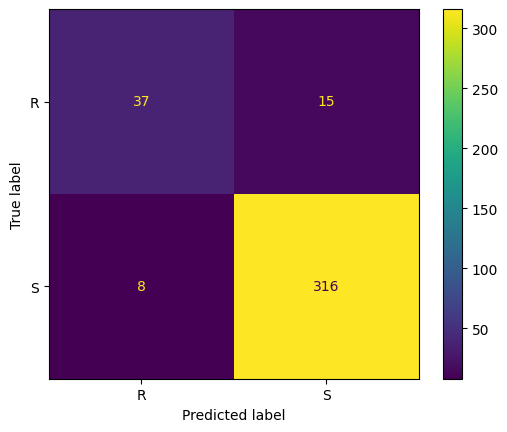

Results
Accuracy: 0.9388297872340425
R recall: 0.7115384615384616
S recall: 0.9753086419753086
R precision: 0.8222222222222222
S precision: 0.9546827794561934


In [19]:
Model_Report = evaluate(LG_CTZ_GY_model, CTZ_Train_test_dic['labels_test'], CTZ_GY_labels_pred)

In [20]:
hparam = {"C":[0.001, 0.01, 0.1, 1.00]}

In [21]:
@ignore_warnings(category=ConvergenceWarning)
def LG_hp_tune(param, feat_train_df, lab_train, v=3, cv=4):
  model = LogisticRegression(random_state = 42, max_iter=500, class_weight='balanced', n_jobs=2)
  scoring_dic = {'f1_macro':make_scorer(f1_score , average='macro')}
  feat = feat_train_df.drop(columns=["MLST"])
  lab_train_t = lab_train.replace({'R': 0, 'S': 1})
  if str(cv).isnumeric():
    cv = KFold(cv)
    gs = GridSearchCV(model, param, scoring=scoring_dic,cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat, lab_train_t)
  elif cv == "blocked":
    groups= feat_train_df['MLST']
    cv = StratifiedGroupKFold(n_splits=4)
    gs = GridSearchCV(model, param, scoring=scoring_dic,cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat, lab_train_t, groups=groups)
  else:
    print("Please provide a valid crossvalidation scheme `blocked` or an integer")
  print(gs.best_params_)
  print(gs.best_score_)
  return gs.best_estimator_

In [22]:
LG_tuned = LG_hp_tune(hparam, CTZ_GY_train_feat, CTZ_Train_test_dic['labels_train'])

<ipython-input-21-7944d1a30141>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lab_train_t = lab_train.replace({'R': 0, 'S': 1})


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ....C=0.001; f1_macro: (train=0.734, test=0.751) total time=  22.3s
[CV 2/4] END ....C=0.001; f1_macro: (train=0.732, test=0.696) total time=  21.0s
[CV 3/4] END ....C=0.001; f1_macro: (train=0.746, test=0.665) total time=  18.9s
[CV 4/4] END ....C=0.001; f1_macro: (train=0.738, test=0.692) total time=  18.9s
[CV 1/4] END .....C=0.01; f1_macro: (train=0.904, test=0.840) total time=  19.8s
[CV 2/4] END .....C=0.01; f1_macro: (train=0.899, test=0.795) total time=  18.7s
[CV 3/4] END .....C=0.01; f1_macro: (train=0.910, test=0.711) total time=  19.8s
[CV 4/4] END .....C=0.01; f1_macro: (train=0.923, test=0.792) total time=  19.6s
[CV 1/4] END ......C=0.1; f1_macro: (train=0.988, test=0.867) total time=  20.2s
[CV 2/4] END ......C=0.1; f1_macro: (train=0.979, test=0.816) total time=  20.2s
[CV 3/4] END ......C=0.1; f1_macro: (train=0.988, test=0.769) total time=  20.2s
[CV 4/4] END ......C=0.1; f1_macro: (train=0.990,

In [23]:
CTZ_GY_tuned_pred = predict(LG_tuned,CTZ_GY_test_df)

print("Labels predicted: ", np.unique(CTZ_GY_tuned_pred, return_counts=True))

Labels predicted:  (array(['R', 'S'], dtype=object), array([ 45, 331]))


In [24]:
Model_Report = evaluate(LG_CTZ_GY_model, CTZ_Train_test_dic['labels_test'], CTZ_GY_labels_pred, cf=False)

Results
Accuracy: 0.9388297872340425
R recall: 0.7115384615384616
S recall: 0.9753086419753086
R precision: 0.8222222222222222
S precision: 0.9546827794561934


In [25]:
Tuned_Model_Report = evaluate(LG_tuned, CTZ_Train_test_dic['labels_test'], CTZ_GY_tuned_pred, cf=False)

Results
Accuracy: 0.9281914893617021
R recall: 0.6730769230769231
S recall: 0.9691358024691358
R precision: 0.7777777777777778
S precision: 0.9486404833836858


In [26]:
print(drug_list)

print(combo_list)

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')
['Y', 'G', 'GY']


In [27]:
for fname in os.listdir(filepath):
    if fname.endswith('LG_metrics_df.csv'):
        print("A csv with stored results for Logistic Regression has already been created. Please check your Google Drive directory.")
        break
else:
  LG_model_metrics = {}

  for drug in drug_list:
    print(drug)
    Test_Train_dic = Split_train_test_antibiotic(drug)
    for combo in combo_list:
      labels_train = Test_Train_dic["labels_train"]
      features_train = combo_feat(Test_Train_dic["features_train"], drug, combo)
      print(drug+"_"+combo)

      LG_combo_model = run_LG(features_train, labels_train, drug, combo)

      features_test = combo_feat(Test_Train_dic["features_test"], drug, combo)
      labels_pred = predict(LG_combo_model, features_test)
      labels_test = Test_Train_dic["labels_test"]
      report = evaluate(LG_combo_model, labels_test, labels_pred, cf=False, show_results=False)
      LG_model_metrics[drug+"_"+combo] = report
      print(report)
  LG_metrics = pd.DataFrame.from_dict(LG_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision"]).reset_index()
  LG_metrics = LG_metrics.rename(columns = {'index':'Drug_combo'})

  LG_metrics.to_csv(filepath+"LG_metrics_df.csv", index= False)

CTZ
CTZ_Y
CTZ Training combo: Y
[0.6276595744680851, 0.4230769230769231, 0.6604938271604939, 0.16666666666666666, 0.8770491803278688]
CTZ_G
CTZ Training combo: G
[0.9335106382978723, 0.6346153846153846, 0.9814814814814815, 0.8461538461538461, 0.9436201780415431]
CTZ_GY
CTZ Training combo: GY
[0.9388297872340425, 0.7115384615384616, 0.9753086419753086, 0.8222222222222222, 0.9546827794561934]
CTX
CTX_Y
CTX Training combo: Y
[0.628808864265928, 0.5394736842105263, 0.6526315789473685, 0.29285714285714287, 0.8416289592760181]
CTX_G
CTX Training combo: G
[0.9556786703601108, 0.868421052631579, 0.9789473684210527, 0.9166666666666666, 0.9653979238754326]
CTX_GY
CTX Training combo: GY
[0.9473684210526315, 0.868421052631579, 0.968421052631579, 0.88, 0.965034965034965]
AMP
AMP_Y
AMP Training combo: Y
[0.5732484076433121, 0.5294117647058824, 0.7105263157894737, 0.8513513513513513, 0.3253012048192771]
AMP_G
AMP Training combo: G
[0.8535031847133758, 0.9243697478991597, 0.631578947368421, 0.88709677

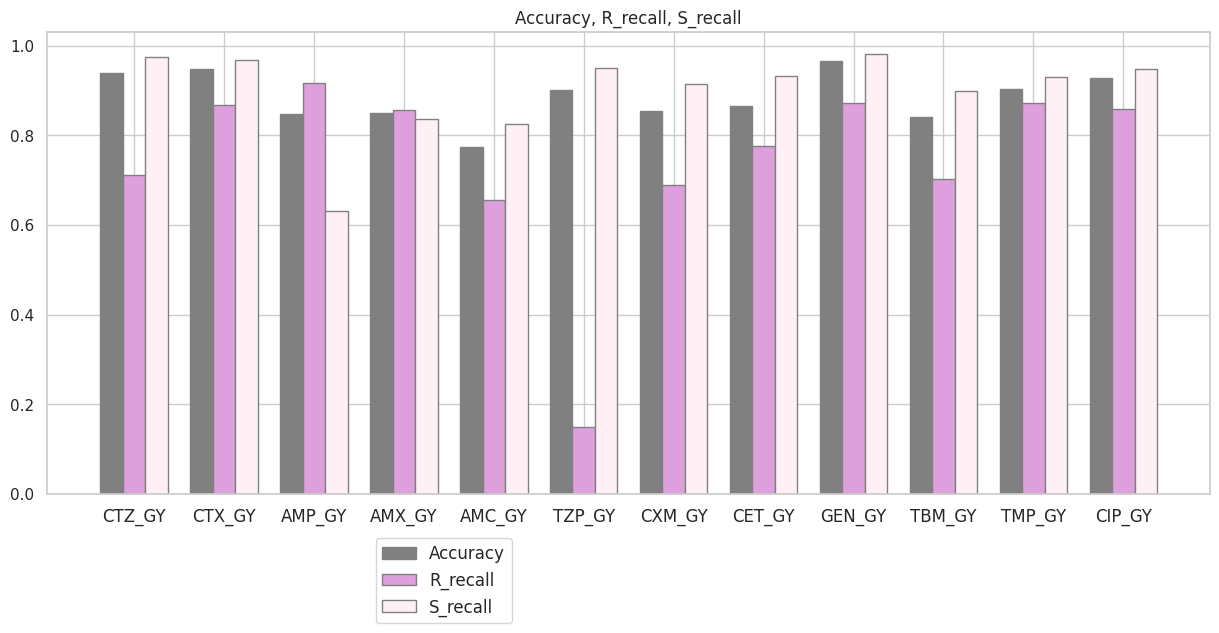

In [28]:
try:
  os.mkdir('/content/drive/My Drive/EColi_ML_Plots')
except:
  print("A directory was already created to store your plot")

LG_metrics = pd.read_csv("/content/drive/MyDrive/EColi_ML_CSV_files/LG_metrics_df.csv")
GY_filter = [drug_combo for drug_combo in LG_metrics['Drug_combo'] if drug_combo.endswith("GY")]
GY_df = LG_metrics.loc[LG_metrics["Drug_combo"].isin(GY_filter)]

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize =(15, 6))

plt.title('Accuracy, R_recall, S_recall', fontsize = 12)

x = np.arange(len(GY_df["Drug_combo"]))
acc = list(GY_df["Accuracy"])
R_rec = list(GY_df["R_recall"])
S_rec = list(GY_df["S_recall"])

acc_bar=plt.bar(x-0.25, height= acc, width=0.25, color="grey", edgecolor="gray")
rrec_bar=plt.bar(x, height= R_rec, width=0.25, color="plum", edgecolor="gray")
srec_bar=plt.bar(x+0.25, height= S_rec, width=0.25, color="lavenderblush", edgecolor="gray")

plt.xticks([r for r in range(len(GY_df["Drug_combo"]))],
            GY_df["Drug_combo"], fontsize = 12)

fig.legend([acc_bar,rrec_bar,srec_bar],["Accuracy", "R_recall", "S_recall"], bbox_to_anchor=(0.4,-0.35, 0.04, 0.4), fontsize=12)

plt.savefig('/content/drive/My Drive/EColi_ML_Plots/LG_GY_Accuracy_and_Recall_Scores.jpg',dpi=400, bbox_inches="tight")

plt.show()